## Dataset exploration of CEReD

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import regex as re
from pandas.api.types import CategoricalDtype

import warnings
warnings.filterwarnings('ignore') # parameters : default or ignore

In [2]:
# anonymized subset of czech diaries collected from the candidate student teachers.
diaries = pd.read_csv('./run_to_cluster/data/diaries/cs/diaries.tsv',sep='\t')
print(len(diaries))
diaries.head()

950


,id,person_id,subject,ordering,Q1,Q2,Q3,Q4,Q5,Q6,Q7,diary
0,0,1,český jazyk,1,1,1,1,1,1,1,1,Zatím jsem absolvovala náslechové hodiny v hod...
1,1,1,český jazyk,2,1,1,1,1,1,1,1,"Jsem ráda, že jsem si vybrala školu, kterou na..."
2,2,1,český jazyk,3,1,1,1,1,1,1,1,"Praxe už mám skoro za sebou. Je tolik věcí, na..."
3,3,2,český jazyk,1,1,1,2,2,1,2,1,První úkol a co napsat. Sedím pátý den na prax...
4,4,2,český jazyk,2,1,1,2,2,1,2,1,Čtrnáct dní uteklo jako voda a já sedím a přem...


In [3]:
# load the datasets of the sentences, train, val, test sets
# in English
sentences_en_tr = pd.read_csv('./run_to_cluster/data/sentences/en/train/sentences.tsv',sep='\t')
sentences_en_val = pd.read_csv('./run_to_cluster/data/sentences/en/val/sentences.tsv',sep='\t')
sentences_en_te = pd.read_csv('./run_to_cluster/data/sentences/en/test/sentences.tsv',sep='\t')
print(f'In English\nLenght training set : {len(sentences_en_tr)}')
print(f'Lenght validation set : {len(sentences_en_val)}')
print(f'Lenght testing set : {len(sentences_en_te)}')

# in Czech
sentences_cs_tr = pd.read_csv('./run_to_cluster/data/sentences/cs/train/sentences.tsv',sep='\t')
sentences_cs_val = pd.read_csv('./run_to_cluster/data/sentences/cs/val/sentences.tsv',sep='\t')
sentences_cs_te = pd.read_csv('./run_to_cluster/data/sentences/cs/test/sentences.tsv',sep='\t')
print(f'\nIn Czech\nLenght training set : {len(sentences_cs_tr)}')
print(f'Lenght validation set : {len(sentences_cs_val)}')
print(f'Lenght testing set : {len(sentences_cs_te)}')
sentences_en_tr.head(10)


In English
Lenght training set : 6096
Lenght validation set : 339
Lenght testing set : 339

In Czech
Lenght training set : 6096
Lenght validation set : 339
Lenght testing set : 339


,idx,context,sentence,y,confidence,y_requires_context
0,1907,I have to explain to some why I gave them such...,"Unfortunately, I won't have time to get around...",Experience,"[5, 4]",NaN
1,4486,I warn them of mistakes. They read in front of...,"What I liked: They worked, even though they we...",Feeling,"[5, 2]",NaN
2,6544,When I ask MiÅ¡a that maybe all three are work...,Another situation occurred when I asked MÃ­Å¡a...,Experience,"[3, 5]",NaN
3,5966,Pupils reported a lot and enjoyed reading and ...,So far there has been no problem.,Experience,"[4, 4]",NaN
4,6218,"First, I divided the children into groups usin...",The children were given a task in groups and t...,Other,"[6, 6]",NaN
5,3066,Perhaps the most fun thing there is just liste...,"When I came up with activities for them, I wan...",Experience,"[5, 5]",NaN
6,4711,But this debate was humorous and with mutual r...,Pupils had a complete assignment in the Inform...,Other,"[6, 7]",NaN
7,3726,"On the one hand, it was a change for the child...",I think that the involvement of modern technol...,Belief,"[4, 6]",NaN
8,6525,So I'm starting to admire the teacher more and...,But I simply say that it was not easy and some...,Difficulty,"[6, 5]",NaN
9,6122,"We still had a teacher at the high school, who...","Fortunately, she's fine, and from what I've he...",Other,"[6, 5]",NaN


In [7]:
print(f"Unique labels: {sentences_en_tr['y'].unique().tolist()}")

Unique labels: ['Experience', 'Feeling', 'Other', 'Belief', 'Difficulty', 'Intention', 'Learning', 'Reflection', 'Perspective']


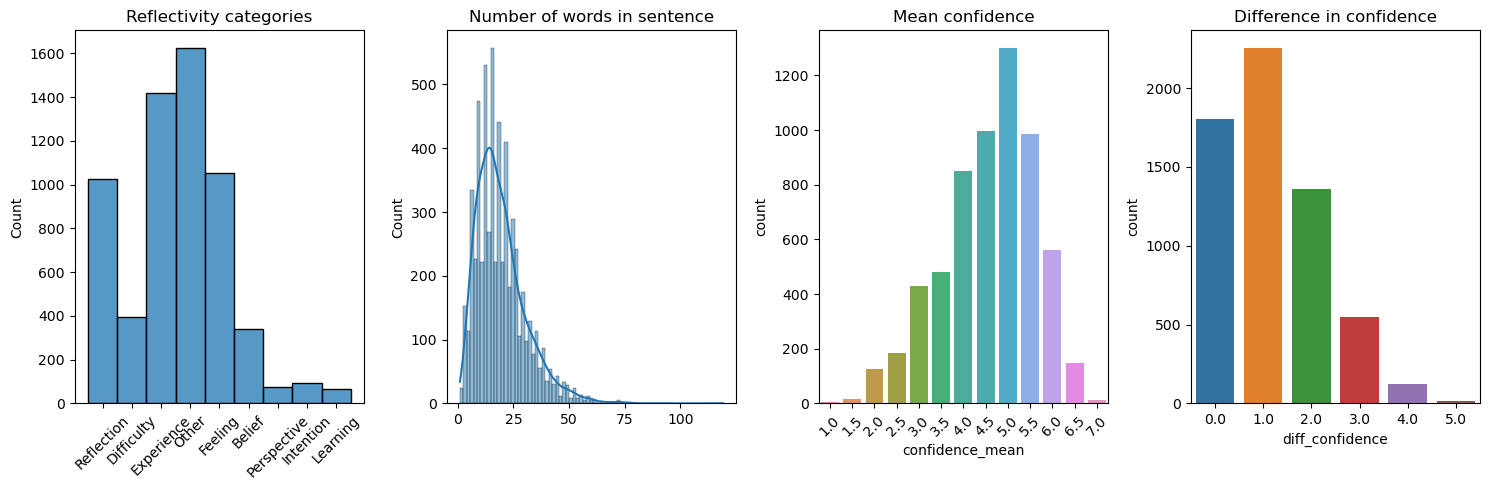

In [9]:
# Applying custom categorical order to training set
df_copy = sentences_en_tr.copy()
M_catType = CategoricalDtype(categories = ['Reflection', 'Difficulty', 'Experience', 'Other', 'Feeling', 'Belief', 'Perspective', 'Intention', 'Learning'], ordered = True)

def add_mean_confidence(df):
    df['confidence_mean'] = np.zeros(len(df))
    for idx, pair in enumerate(df['confidence']):
        df['confidence_mean'].iloc[idx] = np.array(re.findall(r'\d+', pair)).astype(float).mean()
    return df

def add_diff_confidence(df):
    idx_single_conf = []
    df['diff_confidence'] = np.zeros(len(df))
    for idx, pair in enumerate(df["confidence"]):
        pair = np.array(re.findall(r'\d+', pair)).astype(float)
        if len(pair) == 1:
            diff = 0  
            idx_single_conf.append(idx)
        else :
            diff = np.abs(pair[0] - pair[1])
        df['diff_confidence'].iloc[idx] = diff
    return df, idx_single_conf

fig, axs = plt.subplots(1,4, figsize = (15,5))

# categories
df_copy['y'] = df_copy['y'].astype(M_catType)
sns.histplot(df_copy['y'], ax = axs[0])
axs[0].set_title("Reflectivity categories")
axs[0].set_xlabel("")
axs[0].tick_params(axis='x',labelrotation = 45)

# number of words in sentence
sns.histplot([len(str(sentence).split()) for sentence in df_copy['sentence']], ax = axs[1], kde = True)
axs[1].set_title("Number of words in sentence")

# mean confidence
df_copy = add_mean_confidence(df_copy)
sns.countplot(data = df_copy, x = 'confidence_mean', ax=axs[2])
axs[2].set_title(f'Mean confidence')
axs[2].tick_params(axis='x',labelrotation = 45)

#diff confidence
df_copy, _ = add_diff_confidence(df_copy)
sns.countplot(data = df_copy, x = 'diff_confidence', ax=axs[3])
axs[3].set_title(f'Difference in confidence')

plt.tight_layout()
plt.show()


## Exploratory analysis of the English dataset

plot distrib for each train/val/test of:
- nb of words in context
- nb of words in sentence
- y
- confidence (maybe remix the matching pairs like [2,5] and [5,2])
- y_requires_context

In [10]:
def split_sets(set):
    if set == 'tr':
        data = sentences_en_tr
    elif set == 'val':
        data = sentences_en_val
    else:
        data = sentences_en_te
    return data

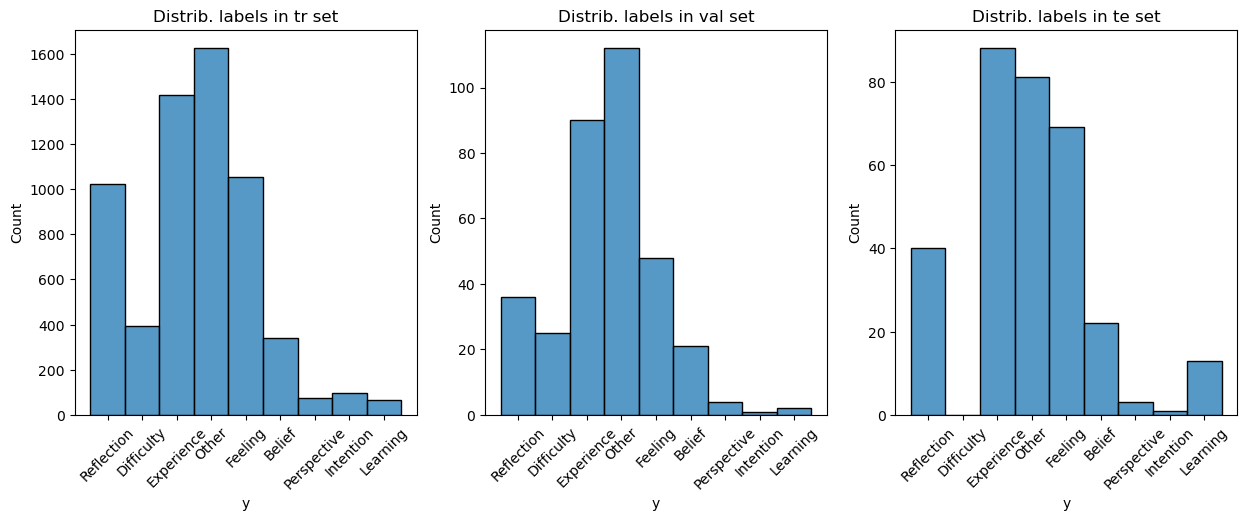

In [11]:
# distribution of labels

# Applying custom categorical order to training set
M_catType = CategoricalDtype(categories = ['Reflection', 'Difficulty', 'Experience', 'Other', 'Feeling', 'Belief', 'Perspective', 'Intention', 'Learning'], ordered = True)

fig, axs = plt.subplots(1,3, figsize = (15,5))
for i, split in enumerate(['tr', 'val', 'te']):
    df = split_sets(split)
    df['y'] = df['y'].astype(M_catType)
    sns.histplot(df['y'], ax = axs[i])
    axs[i].set_title(f'Distrib. labels in {str(split)} set')
    axs[i].tick_params(axis='x',labelrotation = 45)
plt.show()

Mean # words in context for tr, val, te sets : [63.582, 64.186, 63.988]


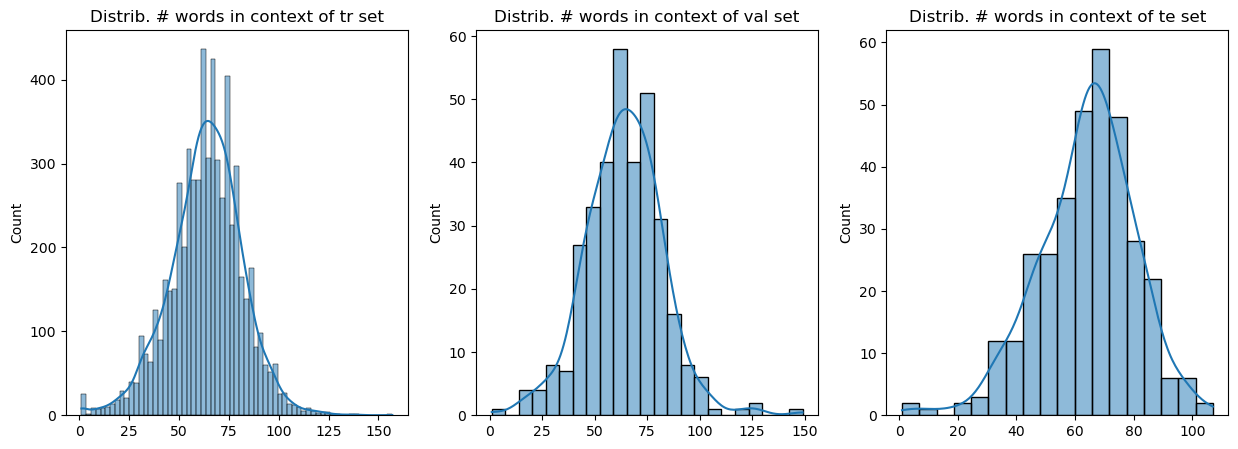

In [12]:
# distributions number of words in context
fig, axs = plt.subplots(1,3, figsize = (15,5))
mean = []
for i, split in enumerate(['tr', 'val', 'te']):
    df = split_sets(split)
    sns.histplot([len(str(sentence).split()) for sentence in df['context']], ax = axs[i], kde = True)
    mean.append(np.mean([len(str(sentence).split()) for sentence in df['context']]).round(3))
    #axs[i].vlines(np.mean([len(str(sentence).split()) for sentence in df['context']]), ymin = 0, ymax = 100, color = 'r', label = 'mean')
    axs[i].set_title(f'Distrib. # words in context of {str(split)} set')
    #axs[i].legend()
print(f'Mean # words in context for tr, val, te sets : {mean}')
plt.show()

Mean # words in sentence for tr, val, te sets : [19.401, 20.012, 19.186]


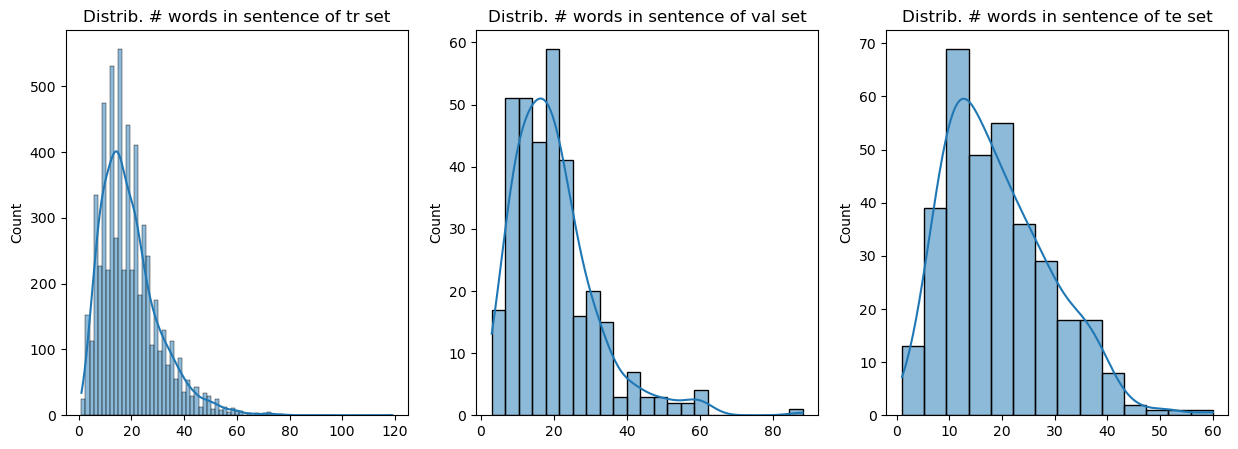

In [13]:
# distributions number of words in sentence
fig, axs = plt.subplots(1,3, figsize = (15,5))
mean = []
for i, split in enumerate(['tr', 'val', 'te']):
    df = split_sets(split)
    sns.histplot([len(str(sentence).split()) for sentence in df['sentence']], ax = axs[i], kde = True)
    mean.append(np.mean([len(str(sentence).split()) for sentence in df['sentence']]).round(3))
    axs[i].set_title(f'Distrib. # words in sentence of {str(split)} set')
print(f'Mean # words in sentence for tr, val, te sets : {mean}')
plt.show()

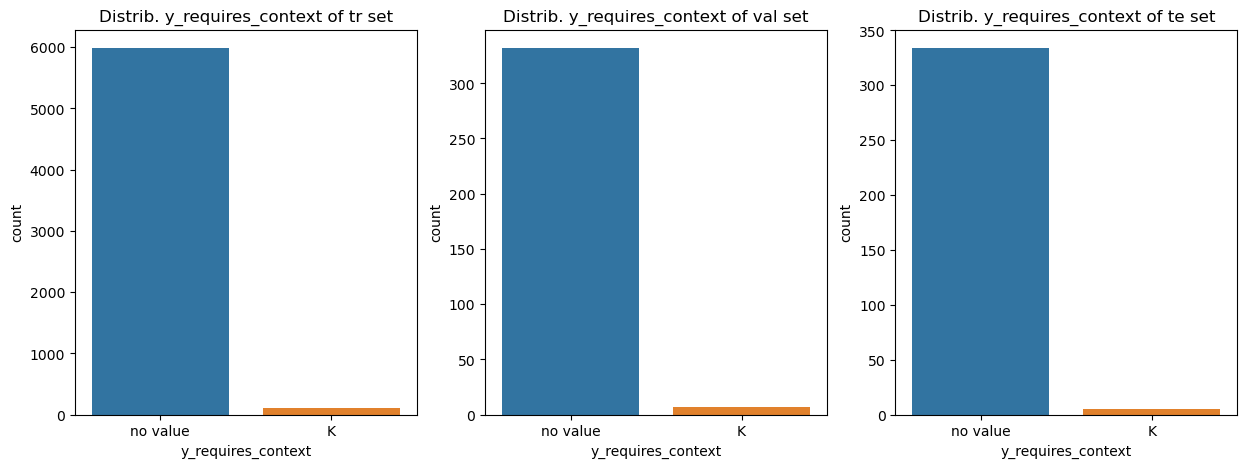

In [14]:
# distributions of y_requires_context
fig, axs = plt.subplots(1,3, figsize = (15,5))
for i, split in enumerate(['tr', 'val', 'te']):
    df_copy = split_sets(split).copy()
    df_copy['y_requires_context'].replace({np.nan : 'no value'}, inplace=True)
    sns.countplot(data = df_copy, x = 'y_requires_context', ax=axs[i])
    axs[i].set_title(f'Distrib. y_requires_context of {str(split)} set')
plt.show()

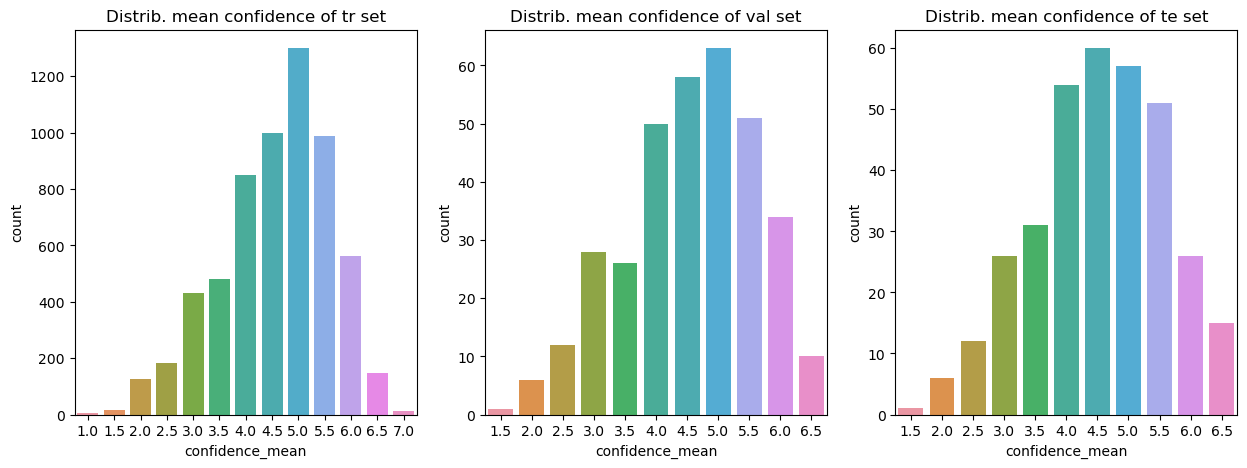

In [15]:
# distributions of confidence averaged
def add_mean_confidence(df):
    df['confidence_mean'] = np.zeros(len(df))
    for idx, pair in enumerate(df['confidence']):
        df['confidence_mean'].iloc[idx] = np.array(re.findall(r'\d+', pair)).astype(float).mean()
    return df

fig, axs = plt.subplots(1,3, figsize = (15,5))
for i, split in enumerate(['tr', 'val', 'te']):
    df_copy = split_sets(split).copy()
    df_copy = add_mean_confidence(df_copy)
    sns.countplot(data = df_copy, x = 'confidence_mean', ax=axs[i])
    #sns.histplot(data = df_copy, x = 'confidence_mean', ax=axs[i])
    axs[i].set_title(f'Distrib. mean confidence of {str(split)} set')
plt.show()

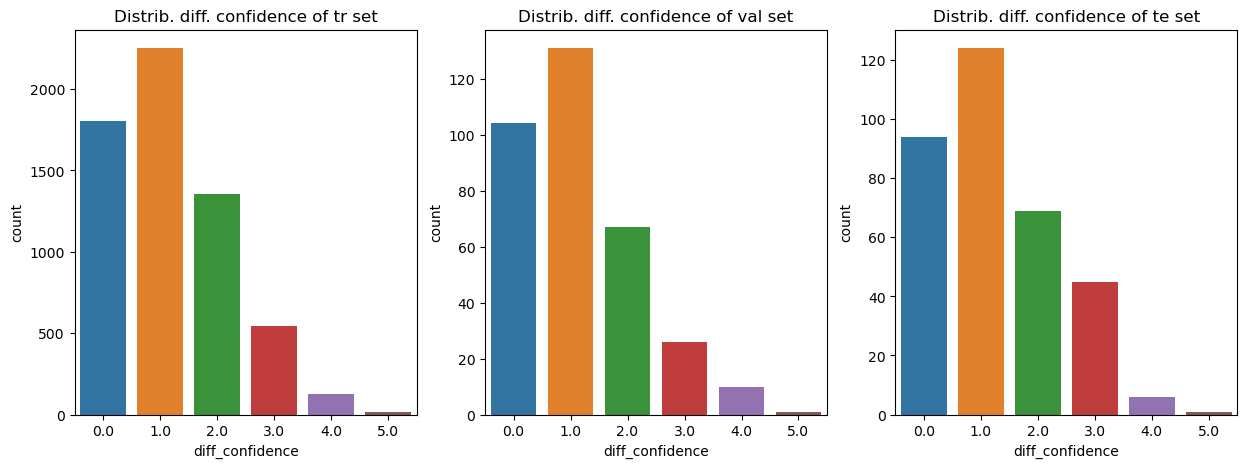

In [16]:
def add_diff_confidence(df):
    idx_single_conf = []
    df['diff_confidence'] = np.zeros(len(df))
    for idx, pair in enumerate(df["confidence"]):
        pair = np.array(re.findall(r'\d+', pair)).astype(float)
        if len(pair) == 1:
            diff = 0  
            idx_single_conf.append(idx)
        else :
            diff = np.abs(pair[0] - pair[1])
        df['diff_confidence'].iloc[idx] = diff
    return df, idx_single_conf

fig, axs = plt.subplots(1,3, figsize = (15,5))
idx_single_conf = [0,0,0]
for i, split in enumerate(['tr', 'val', 'te']):
    df_copy = split_sets(split).copy()
    df_copy, idx_single_conf[i] = add_diff_confidence(df_copy)
    sns.countplot(data = df_copy, x = 'diff_confidence', ax=axs[i])
    axs[i].set_title(f'Distrib. diff. confidence of {str(split)} set')
plt.show()

In [17]:
for i, split in enumerate(['tr', 'val', 'te']):
    perc = 100*len(idx_single_conf[i])/len(split_sets(split))
    print(f'There are {len(idx_single_conf[i])} values with only 1 single confidence, which is {np.round(perc, 3)} % of the {split} dataset.')

There are 61 values with only 1 single confidence, which is 1.001 % of the tr dataset.
There are 6 values with only 1 single confidence, which is 1.77 % of the val dataset.
There are 1 values with only 1 single confidence, which is 0.295 % of the te dataset.


## Exploratory analysis of the diaries dataset

In [19]:
print(f'There are {len(diaries)} reviews for the diaries of {len(diaries["person_id"].unique())} persons concerning {len(diaries["subject"].unique())} subjects.')

# check if their is NaN values
print(f'There are {len(diaries) - len(diaries.dropna())} lines with a NaN value.')

diaries.head()

There are 950 reviews for the diaries of 238 persons concerning 17 subjects.
There are 0 lines with a NaN value.


,id,person_id,subject,ordering,Q1,Q2,Q3,Q4,Q5,Q6,Q7,diary
0,0,1,český jazyk,1,1,1,1,1,1,1,1,Zatím jsem absolvovala náslechové hodiny v hod...
1,1,1,český jazyk,2,1,1,1,1,1,1,1,"Jsem ráda, že jsem si vybrala školu, kterou na..."
2,2,1,český jazyk,3,1,1,1,1,1,1,1,"Praxe už mám skoro za sebou. Je tolik věcí, na..."
3,3,2,český jazyk,1,1,1,2,2,1,2,1,První úkol a co napsat. Sedím pátý den na prax...
4,4,2,český jazyk,2,1,1,2,2,1,2,1,Čtrnáct dní uteklo jako voda a já sedím a přem...


mean = 474.325


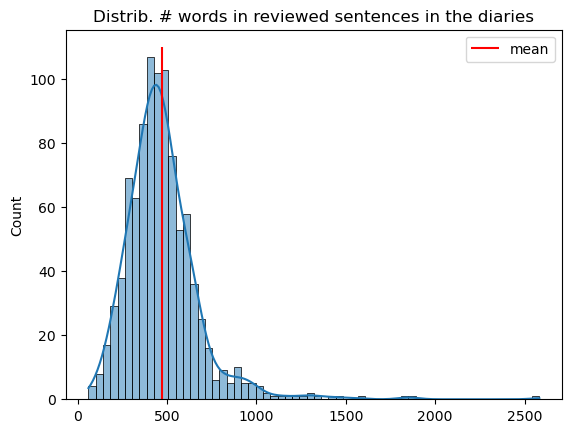

In [20]:
sns.histplot([len(str(sentence).split()) for sentence in diaries['diary']], kde = True)
print(f'mean = {np.mean([len(str(sentence).split()) for sentence in diaries["diary"]]).round(3)}')
plt.vlines(np.mean([len(str(sentence).split()) for sentence in diaries['diary']]).round(3), ymin = 0, ymax = 110, color = 'r', label = 'mean')
plt.title(f'Distrib. # words in reviewed sentences in the diaries')
plt.legend()
plt.show()

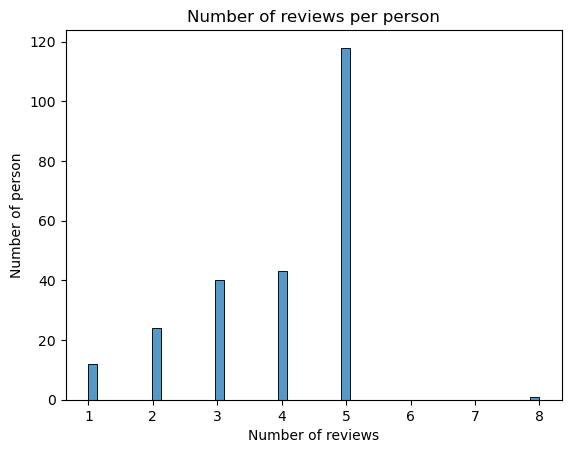

In [21]:
sns.histplot(diaries.groupby('person_id').apply(lambda x : len(x)), bins = 50)
plt.xlabel('Number of reviews')
plt.ylabel('Number of person')
plt.title('Number of reviews per person')
plt.show()

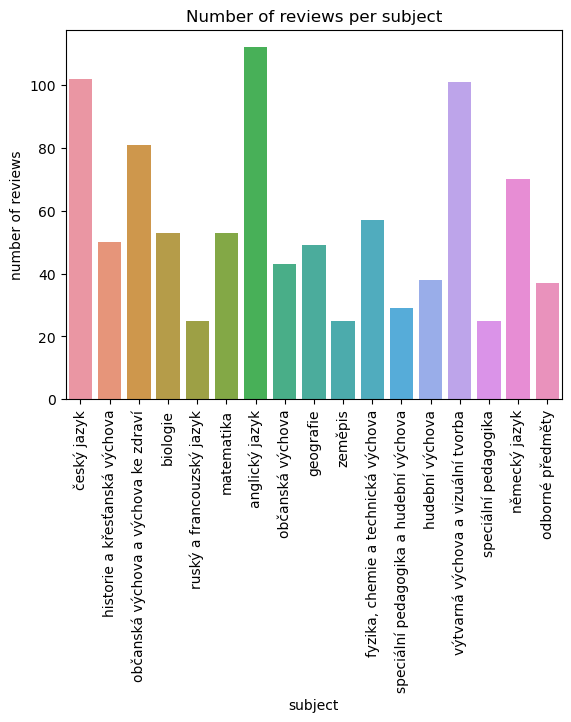

In [22]:
df_subject = pd.DataFrame(index = diaries['subject'].unique(), columns = ['number'])
df_subject['number'] = diaries.groupby('subject').apply(lambda x : len(x))
df_subject.reset_index(inplace=True)

sns.barplot(data = df_subject, x = 'index', y = 'number')
plt.xlabel('subject')
plt.ylabel('number of reviews')
plt.xticks(rotation = 90)
plt.title("Number of reviews per subject")
plt.show()